In [3]:
%matplotlib inline

import sys
import os
import shutil
import time
import traceback
from pathlib import Path
import h5py
import json
import pickle
from types import SimpleNamespace
from importlib import reload

from scipy import signal, stats, spatial, ndimage
from scipy.interpolate import interp1d
from sklearn import linear_model as lm
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

## added TreeMazeanalyses folder using the following command
## conda develop /home/alexgonzalez/Documents/TreeMazeAnalyses2
import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Utils.filter_functions as filter_funcs 
import TreeMazeAnalyses2.Pre_Processing.pre_process_functions as pp_funcs

from TreeMazeAnalyses2.Analyses.subject_info import SubjectInfo, SubjectSessionInfo
from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs

from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)

from ipywidgets import interact, fixed
import ipywidgets as widgets

# 4/8/21: Testing implementation of single encoding model retrieval through subjectinfo class

In [4]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
subject = 'Cl'
session = 'Cl_OF_013119'
session_info = si.SubjectSessionInfo(subject, session)

In [6]:
%%time 
sp_model = session_info.get_encoding_model('speed')

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 27.6 s, sys: 32.5 s, total: 1min
Wall time: 3.28 s


In [13]:
%%time
b = session_info.get_encoding_model('border')

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 17.1 s, sys: 21.3 s, total: 38.4 s
Wall time: 2.14 s


In [23]:
%%time
p = session_info.get_encoding_model('position')

CPU times: user 2min 56s, sys: 2min 57s, total: 5min 54s
Wall time: 21 s


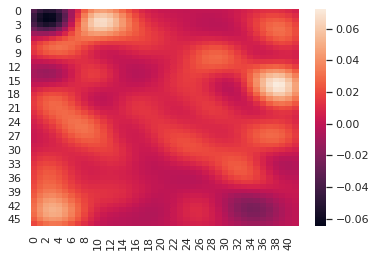

In [37]:
sns.heatmap(p['position']['coeffs'].mean(axis=0)[10].reshape(47,42))

In [22]:
b['border']['coeffs'].mean(axis=0)[0]

array([18.18779251,  6.04282217,  4.32297169,  2.8564932 , 10.63141194,
        3.14377   ])

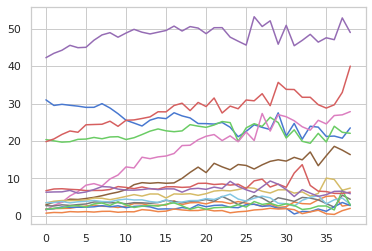

In [12]:
plt.plot(sp_model['speed']['coeffs'].mean(axis=0).T)

# older

In [36]:
n_units = 10
x = pd.DataFrame(np.random.randn(n_units,5), index=range(n_units), columns=['score', 'sig', 'r2', 'rmse', 'nrmse'])
x['analysis_type']='grid'
x['tt'] = 3
x['tt_cl'] = np.arange(n_units)

x = pd.DataFrame(np.random.randn(n_units,5), index=range(n_units), columns=['score', 'sig', 'r2', 'rmse', 'nrmse'])
x['analysis_type']='grid'
x['tt'] = 3
x['tt_cl'] = np.arange(n_units)

,score,sig,r2,rmse,nrmse,analysis_type,tt,tt_cl
0,0.149734,-0.768418,-1.756523,-0.968491,0.598414,grid,3,0
1,1.343004,0.024309,-1.583743,-0.582264,0.253161,grid,3,1
2,-1.040925,0.303380,-0.253038,-0.021466,0.905312,grid,3,2
3,-1.217853,1.065387,-1.898996,-0.073723,1.636080,grid,3,3
4,0.910442,-1.109812,0.671196,-0.842164,-0.216456,grid,3,4
5,1.266657,0.017316,-1.278471,0.433655,-1.662749,grid,3,5
6,0.072913,-1.501025,-0.814944,-0.191755,-0.156814,grid,3,6
7,0.032850,-0.567417,0.181063,-0.743990,0.816168,grid,3,7
8,0.129101,0.854858,0.365312,-2.900889,-0.429579,grid,3,8
9,-0.908614,-0.466764,-2.432825,1.050276,-1.159547,grid,3,9


In [42]:
np.tile(np.arange(n_units),4)
np.repeat(np.array(['sp','hd','border','grid']),n_units)

array(['sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'sp', 'hd',
       'hd', 'hd', 'hd', 'hd', 'hd', 'hd', 'hd', 'hd', 'hd', 'border',
       'border', 'border', 'border', 'border', 'border', 'border',
       'border', 'border', 'border', 'grid', 'grid', 'grid', 'grid',
       'grid', 'grid', 'grid', 'grid', 'grid', 'grid'], dtype='<U6')

In [3]:
subject_id = 'Li'
session = 'Li_OF_060718'
#subject_info = SubjectInfo(subject_id, overwrite=True)
subject_info = SubjectInfo(subject_id)
session_info = SubjectSessionInfo(subject_id,session)
task_params = SimpleNamespace(**session_info.task_params)
n_units = session_info.n_units
print(session_info)
session_info.print_task_params()

number of units in session 37

Session Information for subject Li, session Li_OF_060718
Number of curated units: 37
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> time. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> spike_maps. Executed = True
  -> fr_maps. Executed = True
  -> scores. Executed = False
  -> lnp_scores. Executed = False

To run all analyses use run_analyses().


Task/track and analysis parameters. 

  -> time_step: 0.02
  -> x_pix_lims: [100, 650]
  -> y_pix_lims: [100, 500]
  -> x_pix_bias: -380
  -> y_pix_bias: -280
  -> vt_rate: 0.016666666666666666
  -> xy_pix_rot_rad: 1.6507963267948966
  -> x_pix_mm: 3.7790697674418605
  -> y_pix_mm: 3.265765765765766
  -> x_mm_bias: 20
  -> y_mm_bias: 650
  -> x_mm_lims: [-630, 630]
  -> y_mm_lims: [-60, 1350]
  -> x_cm_lims: [-63, 63]
  -> y_cm_lims: [-6, 135]
  -> mm_bin: 30
  -> cm_bin: 3
  -> max_

In [13]:
subject_info.sort_tables['valid']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Li_T3g_052818,NaN,15,NaN,NaN,18,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Li_OF_052818,NaN,18,NaN,18,17,22,16,18,NaN,NaN,NaN,NaN,16,NaN,NaN,NaN
Li_T3g_052918,NaN,16,10,NaN,NaN,NaN,17,16,14,16,NaN,NaN,16,16,16,16
Li_OF_052918,NaN,18,14,NaN,NaN,24,16,19,18,16,NaN,NaN,18,16,NaN,16
Li_OF_053018,12,16,13,NaN,NaN,16,20,18,17,14,NaN,NaN,25,16,NaN,19
Li_T3g_053018,NaN,9,10,NaN,NaN,13,16,18,15,15,NaN,NaN,15,16,12,17
Li_OF_053118,NaN,NaN,10,NaN,NaN,23,22,19,18,18,NaN,NaN,4,17,NaN,18
Li_T3g_053118,NaN,16,10,NaN,15,17,17,17,16,16,NaN,NaN,10,18,16,16
Li_T3g_060118,NaN,NaN,11,NaN,9,17,16,17,15,17,NaN,NaN,7,16,13,23
Li_OF_060118,NaN,16,11,NaN,7,23,25,19,NaN,16,NaN,NaN,NaN,16,17,20


In [18]:
# load data
spks,_,_ = session_info.get_spikes()
bs = session_info.get_binned_spikes()
fr = session_info.get_fr()
t_rs = session_info.get_time()
of_dat = session_info.get_track_data() 
of_dat = SimpleNamespace(**of_dat)
spike_maps = session_info.get_spike_maps()
fr_maps = session_info.get_fr_maps()

Spikes Files not Found or overwrite=1, creating them.
Binned Spikes Files not Found or overwrite=1, creating them.
Spikes Files not Found or overwrite=1, creating them.
Firing Rate Files Not Found or overwrite=1, creating them.
Open Field Track Data not Found or Overwrite= True, creating them.
Open Field Spike Maps not Found or Overwrite= True, creating them.
Open Field Firing Rate Maps not Found or Overwrite= True, creating them.


In [31]:
maps = np.zeros((10))
maps.reshape(1,-1).shape
#maps[np.newaxis, ].shape

(1, 10)

In [19]:
spatial_funcs = reload(spatial_funcs)
spatial_funcs.get_border_encoding_model(of_dat.x, of_dat.y, fr, fr_maps, task_params.x_bin_edges_, task_params.y_bin_edges_)

(    solstad_score  solstad_sig       aR2       rmse     nrmse
 0        0.364803          1.0  0.003837   5.030571  2.199636
 1        0.419546          1.0  0.017009  11.583824  0.936995
 2        0.424479          1.0  0.024745  10.782260  1.034362
 3        0.409651          1.0  0.038320   6.595632  1.067205
 4        0.405837          1.0  0.016980  24.574617  0.749446
 5        0.468619          0.0  0.022536   6.960973  1.823718
 6        0.494666          0.0  0.013591   6.821572  1.945194
 7        0.386649          1.0  0.001496   4.930943  2.207164
 8        0.444261          0.0  0.003278   8.023617  1.726517
 9        0.419920          1.0  0.004717   8.479417  1.257281
 10       0.270802          0.0  0.044933   6.247112  2.267360
 11       0.560800          0.0  0.011660   7.341082  2.351344
 12      -0.103409          1.0  0.068132   6.988496  1.478502
 13       0.557231          0.0  0.041279   6.243388  1.846777
 14       0.185246          1.0  0.069306   7.331054  1

In [46]:
def plot_fr_map(unit):
    f, ax = plt.subplots()
    ax = sns.heatmap(fr_maps[unit], ax=ax)
    ax.invert_yaxis()
    

interact(plot_fr_map, unit=widgets.IntSlider(min=0, max=n_units-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='unit', max=36), Output()), _dom_classes=('widget-interac…

<function __main__.plot_fr_map(unit)>

In [25]:
scores = pd.DataFrame(index=range(n_units),
                          columns=['vec_len', 'mean_ang','rayleigh',  'p_val', 'sig', 'var_ang', 'std_ang'])

alpha=0.02
for unit in range(n_units):
    vec_len, mean_ang, var_ang, std_ang, = rs.resultant_vector_length(alpha=hd[valid_samps], w=fr[unit][valid_samps])
    p_val, rayleigh = rs.rayleigh(alpha=hd[valid_samps], w=fr[unit][valid_samps])
    out_dir = {'vec_len': vec_len, 'mean_ang': np.mod(mean_ang, 2*np.pi), 'rayleigh': rayleigh, 'p_val': p_val, 'sig': p_val<alpha, 'var_ang': var_ang,
                   'std_ang': std_ang}

    scores.loc[unit] = np.array([val for key,val in out_dir.items()])

scores

,vec_len,mean_ang,rayleigh,p_val,sig,var_ang,std_ang
0,0.0439832,1.97064,1527.99,0,1,0.956017,2.49958
1,0.141234,0.754557,3825.16,0,1,0.858766,1.97855
2,0.321559,1.52139,14165.7,0,1,0.678441,1.50637
3,0.11229,2.1556,1570.49,0,1,0.88771,2.09126
4,0.330249,0.136907,14961.5,0,1,0.669751,1.48856
5,0.336173,2.95688,13715.4,0,1,0.663827,1.47657
6,0.299722,6.01634,36648.9,0,1,0.700278,1.55235
7,0.238859,2.15285,5378.47,0,1,0.761141,1.69227
8,0.0867761,2.85956,178.329,2.55983e-78,1,0.913224,2.21107
9,0.094004,3.43103,828.668,0,1,0.905996,2.17459


Open Field Spike Maps not Found or Overwrite= True, creating them.
Open Field Firing Rate Maps not Found or Overwrite= True, creating them.


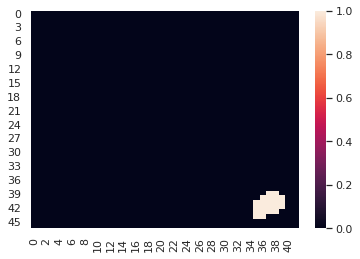

In [26]:
sns.heatmap(of_dat.pos_map_secs>1)

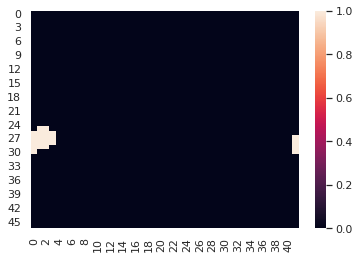

In [57]:
thr_map = of_dat.pos_map_secs>1

field_idx = np.argwhere(thr_map)
                  
height,width = thr_map.shape


moved_fields = field_idx + np.array([np.random.randint(dim) for dim in thr_map.shape])
moved_fields[:,0]  = np.mod(moved_fields[:,0], height)
moved_fields[:,1]  = np.mod(moved_fields[:,1], width)
moved_map = np.zeros_like(thr_map)
moved_map[moved_fields[:,0],moved_fields[:,1]]=1

sns.heatmap(moved_map)

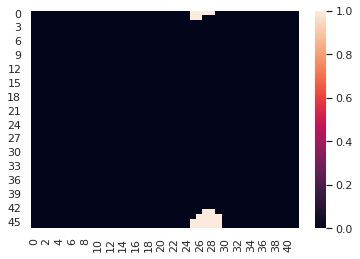

In [56]:

sns.heatmap(moved_map)

In [61]:
field_maps, n_fields = spatial_funcs.get_map_fields(of_dat.pos_map_secs, 0.5, 20)


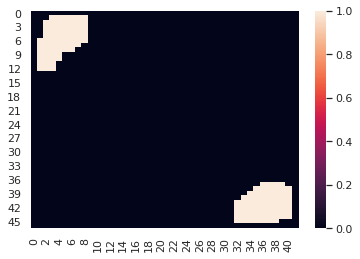

In [66]:
sns.heatmap(field_maps>=0)

1.0

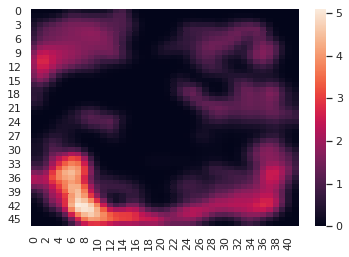

In [26]:
unit=11
fr_map = fr_maps[unit]
fr_thr = 0.3
max_fr = fr_map.max()
sns.heatmap(fr_map)

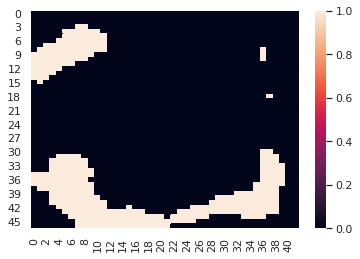

In [28]:
thr_map = fr_map>=fr_thr*max_fr
sns.heatmap(thr_map)

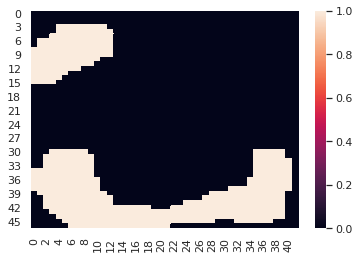

In [52]:
thr_map = fr_map>=fr_thr*max_fr
border_mask = np.ones_like(fr_map, dtype=bool)
border_mask[[0,-1],:] = False
border_mask[:,[0,-1]] = False

# eliminates small
thr_map2=ndimage.binary_opening(thr_map,structure=np.ones((3,3)))
thr_map2=ndimage.binary_closing(thr_map2,structure=np.ones((3,3)), mask=border_mask)
thr_map3=ndimage.binary_dilation(thr_map2,structure=np.ones((3,3)))

sns.heatmap(thr_map3)

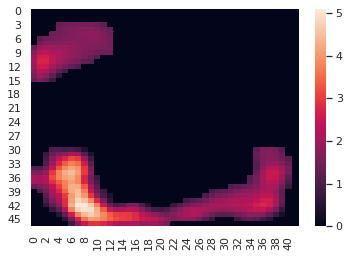

In [93]:
# get field ids
fields_map, n_fields = ndimage.label(thr_map3, structure=np.ones((3,3)))

#check for small fields
field_sizes_cm2 = np.zeros(n_fields)
bin_cm2 =track_params.cm_bin**2
for f in range(n_fields):
    field_sizes_cm2[f] = (np.sum(fields_map==f)*bin_cm2)
    
min_field_size_cm2 = 200
if np.any(field_sizes_cm2<min_field_size_cm2):
    small_fields = np.where(field_sizes_cm2<min_field_size_cm2)[0]
    for f in small_fields:
        thr_map3[fields_map==f] = 0
    fields_map, n_fields = ndimage.label(thr_map3, structure=np.ones((3,3)))

fields_map-=1 # zero-center
sns.heatmap(fr_map*(fields_map>=0))

In [94]:
fields_map

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ...,  1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int32)

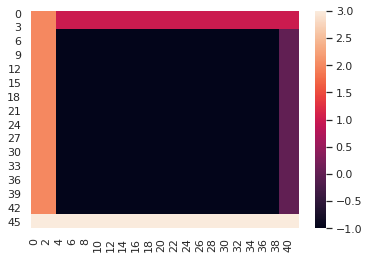

In [95]:
border_width = track_params.border_dist_bin  
map_height, map_width = fr_map.shape # in bins
border_wide_mask = np.ones_like(fr_map, dtype=int)*-1
border_wide_mask[:, map_width:(map_width-border_width):-1] = 0 # right / East
border_wide_mask[0:border_width,:] = 1 # top / North
border_wide_mask[:, 0:border_width] = 2 # left / West
border_wide_mask[map_height:(map_height-border_width):-1,:] = 3 # bottom / Sout

sns.heatmap(border_wide_mask)

In [74]:
def get_distance_mat(h,w):

    a = np.arange(h)
    b = np.arange(w)
    
    r_h = np.minimum(a,a[::-1])
    r_w = np.minimum(b,b[::-1])
    pyr = np.minimum.outer(r_h,r_w)
    return pyr/np.max(pyr)

def get_wall_labels(map_height, map_width, wall_width):
    
    mask = np.ones((4,map_height, map_width), dtype=int)*-1

    mask[0][:, map_width:(map_width-wall_width):-1] = 0 # right / East
    mask[1][0:wall_width,:] = 1 # top / North
    mask[2][:, 0:wall_width] = 2 # left / West
    mask[3][map_height:(map_height-wall_width):-1,:] = 3 # bottom / South

    return mask

def get_map_fields(fr_maps, fr_thr=0.3, min_field_size=20, filt_structure=None):
    """
    gets labeled firing rate maps. works on either single maps or an array of maps.
    returns an array of the same dimensions as fr_maps with 
    :param fr_maps: np.ndarray, (dimensions can be 2 or 3), if 3 dimensions, first dimensions must 
                    correspond to the # of units, other 2 dims are height and width of the map
    :param fr_thr: float, proportion of the max firing rate to threshold the data
    :param min_field_size: int, # of bins that correspond to the total area of the field. fields found 
                    under this threshold are discarded
    :param filt_strcutre: 3x3 array of connectivity. see ndimage for details
    :return field_labels (same dimensions as input), -1 values are background, each field has an int label
    
    -> code based of the description on Solstad et al, Science 2008
    """
    if filt_structure is None:
        filt_structure = np.ones((3,3))
    
    # add a singleton dimension in case of only one map to find fields.
    if fr_maps.ndim == 2:
        fr_maps = fr_maps[np.newaxis,:,:]
    elif fr_maps.ndim ==1:
        print('fr_maps is a one dimensional variable.')
        return None
    
    n_units, map_height, map_width = fr_maps.shape
    
    # create border mask to avoid elimating samples during the image processing step
    border_mask = np.ones((map_height,map_width), dtype=bool)
    border_mask[[0,-1],:] = False
    border_mask[:,[0,-1]] = False
    
    # determine thresholds
    max_fr = fr_maps.max(axis=1).max(axis=1)
    
    # get fields
    field_maps = np.zeros_like(fr_maps)
    n_fields = np.zeros(n_units, dtype=int)
    for unit in range(n_units):
        # threshold the maps
        thr_map = fr_maps[unit] >= max_fr[unit]*fr_thr
        
        # eliminates small/noisy fields, fills in gaps
        thr_map = ndimage.binary_closing(thr_map, structure=filt_structure, mask=border_mask)
        thr_map = ndimage.binary_dilation(thr_map, structure=filt_structure)
    
        # get fields ids
        field_map, n_fields_unit = ndimage.label(thr_map, structure=filt_structure)
        
        # get the area of the fields in bins
        field_sizes = np.zeros(n_fields_unit)
        for f in range(n_fields_unit):
            field_sizes[f] = np.sum(field_map==f)
            
        # check for small fields and re-do field identification if necessary
        if np.any(field_sizes<min_field_size):
            small_fields = np.where(field_sizes<min_field_size)[0]
            for f in small_fields:
                thr_map[field_map==f] = 0
            field_map, n_fields_unit = ndimage.label(thr_map, structure=filt_structure)
        
        # store
        field_maps[unit] = field_map
        n_fields[unit] = n_fields_unit
    
    field_maps -= 1 # make background -1, labels start at zero
    
    # if only one unit, squeeze to match input dimensions
    if n_units==1:
        field_maps = field_maps.squeeze()
        
    return field_maps, n_fields

def get_border_scores(fr_maps, params, field_maps=None):
    """
    
    -> code based of the description on Solstad et al, Science 2008
    """
    n_walls = 4
    # add a singleton dimension in case of only one map to find fields.
    if fr_maps.ndim == 2:
        fr_maps = fr_maps[np.newaxis,]
    n_units, map_height, map_width = fr_maps.shape 
    
    # refactor parameters
    p = SimpleNamespace(**params)
    
    # get fields
    if field_maps is None:
        field_maps, n_fields = get_map_fields(fr_maps, fr_thr=p.fr_thr, min_field_size=p.min_field_size_bins)
    
    if field_maps.ndim ==2:
        field_maps = field_maps[np.newaxis,]

    # get border distance matrix
    distance_mat = get_distance_mat(map_height,map_width) # linear distance to closest wall [bins]
    
    # get wall labels
    wall_labels_mask = get_wall_labels(map_height, map_width, p.wall_width_bin)
    
    # pre-allocate scores
    border_score = np.zeros(n_units)*np.nan
    max_coverage = np.zeros(n_units)*np.nan
    weighted_fr = np.zeros(n_units)*np.nan
    
    # loop and get scores
    for unit in range(n_units):
        fr_map = fr_maps[unit]
        field_map = field_maps[unit]
        n_fields_unit = n_fields[unit]
        if n_fields_unit > 0:
            # get coverage
            wall_coverage = np.zeros((n_fields_unit,n_walls))
            for field in range(n_fields_unit):
                for wall in range(n_walls):
                    wall_coverage[field,wall] = np.sum((field_map==field)*(wall_labels_mask[wall]==wall))/np.sum(wall_labels_mask[wall]==wall)
            print(wall_coverage)
            c_m = np.max(wall_coverage)
            
            # get normalized distanced weighted firing rate
            field_fr_map = fr_map*(field_map>=0)
            d_m = np.sum(field_fr_map*distance_mat)/np.sum(field_fr_map)
            
            # get border score
            b = (c_m-d_m)/(c_m+d_m)

            border_score[unit] = b
            max_coverage[unit] = c_m
            weighted_fr[unit] = d_m
    
    return border_score, max_coverage, weighted_fr


In [286]:
border_score_params = {'fr_thr': 0.25, 'min_field_cm2': 180, 'min_field_size_bins': 20,'cm_bin': 3, 'cm2_bin': 9, 'wall_width_bin': 2}
get_border_scores(fr_maps, border_score_params)

(array([ 0.50883982,  0.19084953,  0.37685255,  0.49039307,  0.13997581,
         0.52537673,  0.40178044,  0.46679849, -0.04828306,  0.386764  ,
         0.57838982,  0.43741678,  0.45321565,  0.46217321,  0.44512479,
         0.27680883,  0.04298929, -0.03600532,  0.47188181, -0.21231374,
         0.52652025,  0.14006751,  0.45417894, -0.2665978 ,  0.16266578,
         0.50230922,  0.47775977,  0.43765009,  0.46871681,  0.41732915,
         0.23963424,  0.4199814 ]),
 array([1.        , 0.5952381 , 0.86956522, 0.95652174, 0.33333333,
        0.76086957, 0.80952381, 0.98913043, 0.23913043, 0.58695652,
        0.76190476, 0.54761905, 0.73913043, 0.98913043, 0.86956522,
        0.63636364, 0.22826087, 0.13636364, 0.88043478, 0.27272727,
        0.97826087, 0.54545455, 0.84782609, 0.23809524, 0.26190476,
        1.        , 0.98913043, 0.9673913 , 0.98913043, 0.85714286,
        0.43181818, 0.91304348]),
 array([0.32552175, 0.4044484 , 0.3935551 , 0.32706144, 0.25147439,
        0.236745

### test border score method

In [80]:
def test_border_score(height=50,width=30):

    print('Border Score for an east single wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[:,-1]=1 # 
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for a north single wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[0,:]=1 # 
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for a west single wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[:,0]=1 # 
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for a south single wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[-1,:]=1 # 
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for center region')
    dummy_mat = np.zeros((height, width))
    dummy_mat[(height//2-2):(height//2+2),(width//2-2):(width//2+2)]=1
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for thick wall')
    dummy_mat = np.zeros((height, width))
    dummy_mat[0:5,:]=1
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for full coverage')
    dummy_mat = np.ones((height, width))
    print(get_border_scores(dummy_mat, border_score_params)[0])

    print('Border Score for full coverage')
    dummy_mat = np.zeros((height, width))
    print(get_border_scores(dummy_mat, border_score_params)[0])

test_border_score()

Border Score for an east single wall
[[1.         0.06666667 0.         0.06666667]]
[1.]
Border Score for a north single wall
[[0.04 1.   0.04 0.  ]]
[1.]
Border Score for a west single wall
[[0.         0.06666667 1.         0.06666667]]
[1.]
Border Score for a south single wall
[[0.04 0.   0.04 1.  ]]
[1.]
Border Score for center region
[[0. 0. 0. 0.]]
[-1.]
Border Score for thick wall
[[0.12 1.   0.12 0.  ]]
[0.77966102]
Border Score for full coverage
[[1. 1. 1. 1.]]
[0.4354067]
Border Score for full coverage
[[1. 1. 1. 1.]]
[nan]


/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in double_scalars


In [84]:
border_score_params = {'fr_thr': 0.25, 'min_field_cm2': 180, 'min_field_size_bins': 20,'cm_bin': 3, 'cm2_bin': 9, 'wall_width_bin': 2}

height = 47
width = 42
# dummy_mat = np.zeros((height, width))
# dummy_mat[(height//2-2):(height//2+2),(width//2-2):(width//2+2)]=1
dummy_mat = np.ones((height, width))

get_border_scores(dummy_mat, border_score_params)
#sns.heatmap(get_map_fields(dummy_mat)[0])

[[1. 1. 1. 1.]]


(array([0.48812665]), array([1.]), array([0.34397163]))

In [83]:
fr_maps.shape

(32, 47, 42)

In [79]:
d=get_distance_mat(height,width)
np.sum((d*dummy_mat))/np.sum(dummy_mat)

0.325

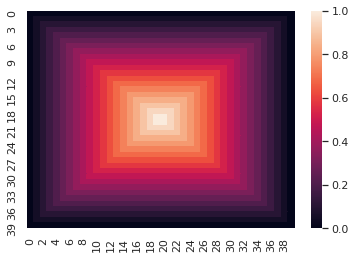

In [77]:
dummy_mat = np.ones((height, width))
#sns.heatmap(dummy_mat)
sns.heatmap(d)

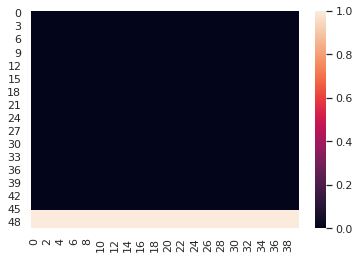

In [21]:
sns.heatmap(get_wall_labels(height,width,5)[3]==3)
#sns.heatmap(get_map_fields(dummy_mat)[0])

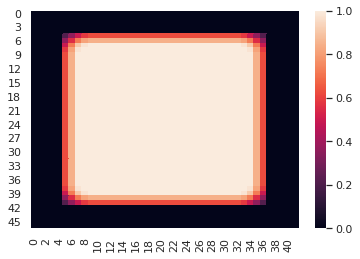

In [37]:
mask = np.zeros_like(of_dat.pos_map_secs)
nb =5
mask[0:nb,:]=1
mask[:,0:nb]=1
mask[:,(nh-nb):nh]=1
mask[(nv-nb):nv:,:]=1
#ax=sns.heatmap(mask)

#sns.heatmap(fr_maps[unit]*mask)
sm_mask=spatial_funcs.get_smoothed_map(mask, track_params.spatial_window_size, track_params.spatial_sigma)
sm_mask[0:nb,:]=1
sm_mask[:,0:nb]=1
sm_mask[:,(nh-nb):nh]=1
sm_mask[(nv-nb):nv:,:]=1
sns.heatmap(1-sm_mask)


In [41]:
p = track_params
x_mask = np.logical_or(of_dat.x<=(p.x_cm_lims[0]+p.boder_dist_cm), of_dat.x>=(p.x_cm_lims[1]+p.boder_dist_cm) )
y_mask = np.logical_or(of_dat.x<=(p.y_cm_lims[0]+p.boder_dist_cm), of_dat.x>=(p.y_cm_lims[1]+p.boder_dist_cm) )
border_samps = np.logical_or(x_mask, y_mask)
border_samps.sum()

17508

In [42]:
center_samps = ~border_samps

array([False, False, False, ...,  True,  True,  True])

## Get speed scores

In [9]:
spatial_funcs = reload(spatial_funcs)

scores, sp_bin_centers, model_coef, model_coef_s  = spatial_funcs.get_speed_score_discrete(of_dat.sp, fr, track_params.speed_bin, track_params.min_speed_thr, track_params.max_speed_thr, track_params.sig_alpha, track_params.n_perm)

In [11]:
spatial_funcs = reload(spatial_funcs)
scores_t, model_coef_t, model_coef_s_t = spatial_funcs.get_speed_score_traditional(of_dat.sp, fr, track_params.min_speed_thr, track_params.max_speed_thr, track_params.sig_alpha, track_params.n_perm)

### get angle score

In [21]:
spatial_funcs = reload(spatial_funcs)
unit = 0 
stats, w_counts, bin_centers, _ = spatial_funcs.get_angle_stats(of_dat.hd, track_params.rad_bin, weights=fr[unit])

In [52]:
spatial_funcs = reload(spatial_funcs)
scores, model_coef, model_coef_s, ang_bin_centers = spatial_funcs.get_angle_scores(of_dat.hd, fr, track_params.rad_bin,
                                                                                  of_dat.sp, track_params.min_speed_thr, 
                                                                                  track_params.max_speed_thr, 
                                                                                  track_params.sig_alpha)

<BarContainer object of 36 artists>

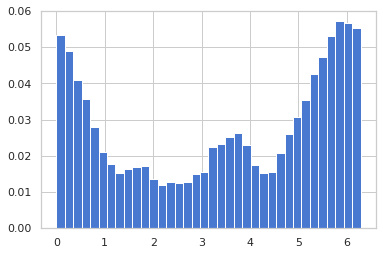

In [48]:
plt.bar(ang_bin_centers, model_coef[6]/model_coef[6].sum(),width=track_params.rad_bin)

In [49]:
scores

,vec_len,mean_ang,sig,aR2,rmse,nrmse
0,0.00296378,1.12674,False,0.020154,20.897231,0.842603
1,0.140538,0.575758,True,0.072632,9.992236,1.633500
2,0.281263,1.48456,True,0.051095,8.194177,1.877444
3,0.0682577,2.24707,False,0.009150,6.741989,1.718977
4,0.317859,0.0430137,True,0.076293,9.852327,2.176025
5,0.290844,2.96596,True,0.094270,6.672701,1.754197
6,0.318225,5.88717,True,0.230632,13.015111,0.978232
7,0.214049,2.2393,True,0.021924,5.738934,1.938810
8,0.0677305,3.41532,False,0.001544,2.888719,3.814629
9,0.102426,3.78631,False,0.006520,5.977538,2.010186


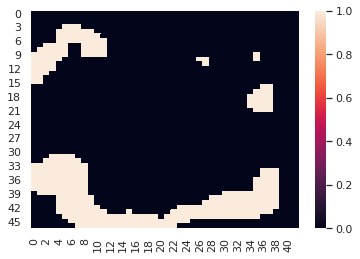

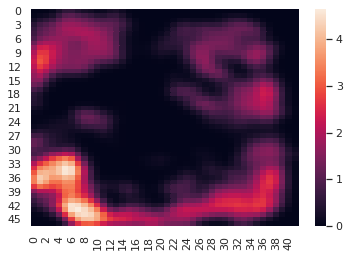

array([-62.59580816,  60.23078349])

In [43]:
np.abs(np.sum(model_coef[6]*np.exp(1j * ang_bin_centers)))

156.7563052317286

In [34]:
fr_hat.shape, fr_valid.shape, n_samps, of_track_dat.sp.shape

((32, 31132), (32, 31132), 31132, (36095,))

In [38]:
rs.get_ar2(fr_valid, fr_hat, 1)

array([ 7.65952777e-03,  1.03453993e-02,  1.15360603e-03,  6.13391178e-03,
        2.59127099e-02,  1.53074521e-03, -2.29824284e-05,  1.13009348e-02,
        1.33714874e-04,  1.06660299e-03,  4.38207083e-04,  9.60497481e-03,
       -2.52884724e-05,  1.72601686e-02,  1.34747440e-02,  7.15572143e-03,
        5.62702178e-04,  4.84713020e-02,  2.55875987e-03,  7.76481367e-04,
        4.13346637e-02,  9.20212794e-04,  1.69700778e-03,  6.05112380e-05,
        2.20818096e-03,  8.09196592e-03,  1.38115483e-02,  1.03372514e-01,
        2.85923619e-02,  9.74768705e-03,  5.75049976e-04,  2.04185912e-02])

(array([832., 776., 840., 737., 667., 655., 570., 599., 553., 526.]),
 array([2.00077527, 2.60058086, 3.20038646, 3.80019205, 4.39999765,
        4.99980324, 5.59960884, 6.19941443, 6.79922003, 7.39902562,
        7.99883122]),
 <a list of 10 Patch objects>)

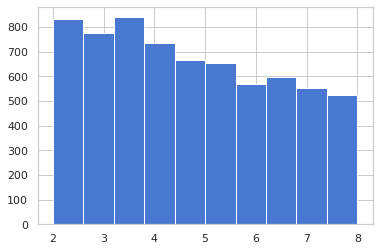

In [32]:
plt.hist(speed_valid)

In [538]:
sp = of_track_dat.sp
min_speed = 2
max_speed = 80
sp_bin_step = 2
sp_valid_idx = np.logical_and(sp>=min_speed, sp<max_speed)
sp_valid = sp[sp_valid_idx]

sp_bin_edges = np.arange(min_speed,max_speed+sp_bin_step, sp_bin_step)
sp_bin_centers = sp_bin_edges[:-1]+sp_bin_step/2
n_sp_bins = len(sp_bin_centers)

sp_ids = np.digitize(sp_valid, bins=sp_bins)
sp_ids = sp_ids-1 # because we had already thresholded speed, need to shift array
assert np.all(sp_ids>=0)

n_samps = len(sp_valid)
design_matrix = np.zeros((n_samps, n_sp_bins))
for i in range(n_sp_bins):
    design_matrix[:,i] = sp_ids==i

### method mean by bin

In [567]:
fr_valid = fr[:, sp_valid_idx]
fr_sp_m = np.zeros( (4, n_units, n_sp_bins) )
fr_sp_s = np.zeros( (n_units, n_sp_bins) )

sp_score = np.zeros((4, n_units))
sp_occ,_ = np.histogram(sp_valid, sp_bin_edges)

for i in range(len(sp_bins)-1):
    fr_sp_m[0, :, i] = np.mean(fr_valid[:, sp_ids == i], axis=1)
    fr_sp_s[:,i] = stats.sem(fr_valid[:, sp_ids == i], axis=1)

### method by weighted histogram

In [599]:
for unit in range(n_units):
    m,_ = np.histogram(sp_valid, sp_bin_edges, weights=fr_valid[unit])
    fr_sp_m[1, unit, :] = m/sp_occ

### method by linear regression

In [600]:
res = lm.LinearRegression(fit_intercept=False).fit(design_matrix, fr_valid.T)
fr_sp_m[2,:,:] = res.coef_

### method by ols statsmodels

In [658]:
import statsmodels.api as sm

for unit in range(n_units):
    model = sm.OLS(fr_valid[unit],design_matrix)
    results = model.fit()
    fr_sp_m[3,unit,:] = results.params

## compare results

In [659]:
for jj in range(4):
    for unit in range(n_units):
        sp_score[jj, unit] = spearman(fr_sp_m[jj,unit],sp_bin_centers)

In [661]:
np.corrcoef(sp_score)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

### simple line /intercept method

In [692]:
sp2_valid = np.column_stack((np.ones(len(sp_valid)), sp_valid))
model = lm.LinearRegression(fit_intercept=False).fit(sp2_valid, fr_valid.T)

In [693]:
model.coef_[0]

array([27.32810099, -0.09581259])

In [690]:
unit=0
model = sm.OLS(fr_valid[unit],sm.add_constant(sp_valid))
results = model.fit()
results.params

array([27.32810099, -0.09581259])

In [701]:
get_ar2(fr_valid[unit],results.predict(sm.add_constant(sp_valid)),1)

array([0.00765953])

In [695]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:              OLS              Adj. R-squared:     0.008      
Dependent Variable: y                AIC:                278040.9680
Date:               2020-08-13 13:07 BIC:                278057.6600
No. Observations:   31132            Log-Likelihood:     -1.3902e+05
Df Model:           1                F-statistic:        241.3      
Df Residuals:       31130            Prob (F-statistic): 3.29e-54   
R-squared:          0.008            Scale:              442.79     
----------------------------------------------------------------------
             Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
----------------------------------------------------------------------
const       27.3281     0.2017   135.4697   0.0000   26.9327   27.7235
x1          -0.0958     0.0062   -15.5335   0.0000   -0.1079   -0.0837
--------------------------------------------------------------------
Omnibus:             5104.575       Durbin-Watson:          0.153   
Prob(Omnibus):       0.000          Jarque-Bera (JB):       8690.394
Skew:                1.084          Prob(JB):               0.000   
Kurtosis:            4.415          Condition No.:          55      
====================================================================

"""

In [703]:
f_hat=results.predict(sm.add_constant(sp_valid))

In [709]:
s = np.std(f_hat-fr_valid[unit])*np.sqrt((n_samps-1)/(n_samps-2))
se_b0 = s*np.sqrt(1+sp_valid.mean()**2/np.var(sp_valid)) / np.sqrt(n_samps)

se_b1 = s/np.sqrt(n_samps)*1/np.std(sp_valid)
print(se_b0,se_b1)

0.20172534297912195 0.006168031880025084


In [710]:
s

21.042213098191905

In [679]:
def get_r2(y, y_hat):
    """
    Coefficient of determination for vectors.
    :param y: array n_samps of dependent variable
    :param y_hat: array of n_samps as a result of a prediction
    :return: R2. float.
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    y_bar = y.mean(axis=1)
    y_bar = y_bar.reshape(-1,1)
        
    return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)

In [677]:
fr_hat = fr_sp_m[1,:,:] @ design_matrix.T


In [685]:

get_mse(fr_valid, fr_hat)
#num = ((fr_valid-fr_hat)**2).sum(axis=1)
#fr_valid-np.mean(fr_valid,axis=1)

array([430.04661894, 106.48214844,  70.63466967,  45.38164746,
        99.27332897,  48.91622408, 217.18773603,  32.98793247,
         8.34715987,  35.91514804,  38.01891918,  17.42747782,
       108.08778394, 316.81089367,  39.64731344,  29.14811116,
         7.8485531 , 217.36345615, 163.61182252, 118.58668196,
       524.09490845, 109.86935218, 225.75664524, 822.46404393,
         9.39360911,  48.53458107,  55.42824913, 520.00922387,
       204.17132111,  46.45558095,  13.15407327, 136.65211589])

In [687]:
unit=1
y=fr_valid[unit]
y_hat=fr_hat[unit]

get_r2(y,y_hat)

array([0.01212684])

In [688]:
np.mean(((y-y_hat)**2))

106.48214844494588

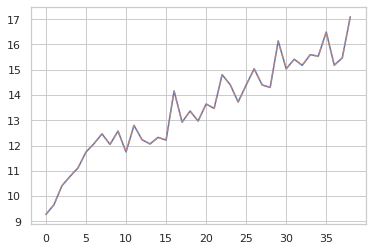

In [544]:
plt.plot(sp_fr)
plt.plot(fr_sp_m[31], '--', alpha=0.7)

In [483]:
fr_sp_m.shape, sp_fr.shape

((32, 40), (39,))

Object `sm.ols` not found.


In [436]:
np.sqrt(np.mean((fr_sp_m @ design_matrix.T - fr)**2,axis=1))/fr.mean(axis=1), rmse_dis

(array([0.9131934 , 1.71471414, 1.96561959, 1.76907767, 2.20433848,
        1.866976  , 1.14391912, 2.00779257, 3.82886351, 2.03119805,
        1.90145548, 2.75518666, 2.5187764 , 0.76068164, 1.85570032,
        2.18133662, 4.00058633, 3.0215473 , 1.46432657, 1.63425985,
        1.30398176, 1.59002714, 1.65637914, 5.27958918, 3.80046155,
        1.64648657, 1.58279463, 0.87533576, 1.04080961, 1.87911529,
        3.28013758, 1.0093489 ]),
 array([0.9131934 , 1.71471414, 1.96561959, 1.76907767, 2.20433848,
        1.866976  , 1.14391912, 2.00779257, 3.82886351, 2.03119805,
        1.90145548, 2.75518666, 2.5187764 , 0.76068164, 1.85570032,
        2.18133662, 4.00058633, 3.0215473 , 1.46432657, 1.63425985,
        1.30398176, 1.59002714, 1.65637914, 5.27958918, 3.80046155,
        1.64648657, 1.58279463, 0.87533576, 1.04080961, 1.87911529,
        3.28013758, 1.0093489 ]))

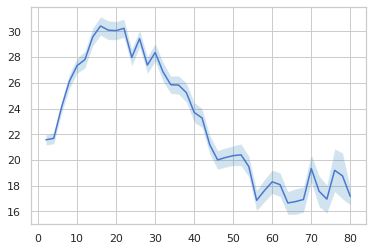

In [368]:
unit=0
f,ax = plt.subplots()        
_= ax.plot(sp_bins, fr_sp_m[unit])
_= ax.fill_between(sp_bins, fr_sp_m[unit]-fr_sp_s[unit], fr_sp_m[unit]+fr_sp_s[unit], facecolor='tab:blue', alpha=0.2)


In [449]:
x=np.zeros((1,100))
x[0]=np.arange(100)
x[0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94., 95., 96., 97., 98., 99.])

In [177]:
np.corrcoef(sp_bins,fr_sp[0])

array([[ 1.        , -0.63971476],
       [-0.63971476,  1.        ]])

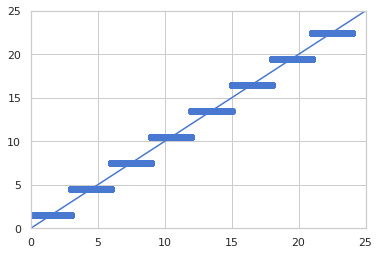

In [103]:
plt.scatter(sp,sp_discrete)
plt.xlim(0,25),
plt.ylim(0,25)
plt.plot([0,25],[0,25])

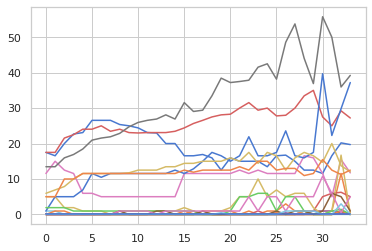

In [300]:
_=plt.plot(fr_sp.T)


In [373]:

# sp2 = np.column_stack((np.ones(len(sp)), sp))
# slopes = np.zeros(n_units)
# ar2 = np.zeros(n_units)
# rmse = np.zeros(n_units)
n_units = session_info.n_units
sp_score = np.zeros(n_units)
sig_sp_score = np.zeros(n_units)
sp_score_pval = np.zeros(n_units)
sp_valid = np.logical_or( sp>=2, sp<=80)
for unit in range(n_units):
#     res = lm.LinearRegression(fit_intercept=False).fit(sp2, fr[unit])
#     slopes[unit]=res.coef_[1]
#     fr_hat = res.predict(sp2)
#     ar2[unit] = get_ar2(fr[unit], fr_hat,1)
#     rmse[unit] = get_nrmse(fr[unit], fr_hat)
    sp_score[unit], sp_score_pval[unit] = stats.spearmanr(sp[sp_valid],fr[unit][sp_valid])

    #sp_score[unit] = spearman(sp,fr[unit])
    sig_sp_score[unit], _ = permutation_test(sp, fr[unit], spearman, n_perm=100)

In [356]:
sp_score

array([-0.03201776,  0.09390081, -0.00659944,  0.12782071, -0.18185802,
       -0.04007809, -0.0448529 ,  0.17547682, -0.00414927, -0.05586335,
       -0.03092611,  0.14464856,  0.06579958,  0.16038789,  0.16198276,
        0.14964059,  0.0495296 , -0.35547771, -0.00556005, -0.02247836,
        0.20861895, -0.01660388, -0.00348127,  0.05071845,  0.08195079,
        0.12265178,  0.15967838,  0.30913352,  0.18482764,  0.13654233,
        0.04613816,  0.17197801])

In [276]:
unit = np.argmin(np.abs(sp_score))
sp_score[unit]

a,b = permutation_test(sp,fr[unit], spearman)

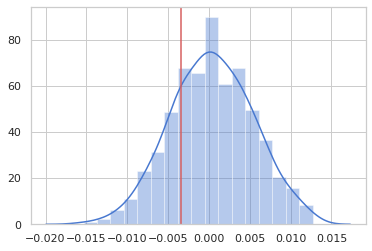

In [266]:
ax=sns.distplot(b)
ax.axvline(sp_score[unit], color='r')

In [284]:
alpha2=0.025
x=(b>=sp_score[unit]).mean()
x, alpha2, x<=alpha2 or x>=1-alpha2

(0.768, 0.025, False)

In [268]:
a,v=stats.spearmanr(sp,fr[unit])
a,v

(-0.003481269636356525, 0.5083721609151224)

In [684]:
def get_r2(y, y_hat):
    """
    Coefficient of determination for vectors.
    :param y: array n_samps of dependent variable;
        can also work with matrices organized as n_samps x n_predictions
    :param y_hat: array with result of a prediction, same shape as y
    :return: R2. float. or array if y,y_hat are matrices. in that case r2 is an array of length n_predictions
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    y_bar = y.mean(axis=1)
    y_bar = y_bar.reshape(-1, 1)

    return 1 - ((y - y_hat) ** 2).sum(axis=1) / ((y - y_bar) ** 2).sum(axis=1)


def get_ar2(y, y_hat, p):
    """
    Adjusted coefficient of determination for number of parameters used in the prediction.
    :param y: array n_samps of dependent variable;
        can also work with matrices organized as n_samps x n_predictions
    :param y_hat: array with result of a prediction, same shape as y
    :param p: number of parameters used in the estimation, excluding bias
    :return: aR2: flaot, adjusted R2. or array if y,y_hat are matrices.
                in that case r2 is an array of length n_predictions
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    n = y.shape[1]
    return 1 - (1 - get_r2(y, y_hat)) * (n - 1) / (n - p - 1)


def get_mse(y, y_hat):
    """
    Mean Square Error Calculation
    :param y: array n_samps of dependent variable;
        can also work with matrices organized as n_samps x n_predictions
    :param y_hat: array with result of a prediction, same shape as y
    :return: mse: float. mean square error. or array of length n_predictions
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    return np.mean((y - y_hat) ** 2, axis=1)


def get_rmse(y, y_hat):
    """
    Root Mean Square Error Calculation
    :param y: array n_samps of dependent variable;
        can also work with matrices organized as n_samps x n_predictions
    :param y_hat: array with result of a prediction, same shape as y
    :return: rmse: float. root mean square error, or array of length n_predictions
    """
    return np.sqrt(get_mse(y, y_hat))


def get_nrmse(y, y_hat):
    """
    Normalized Root Mean Square Error Calculation.
    Divides the RMSE by the mean of variable y
    :param y: array n_samps of dependent variable
    :param y_hat: array of n_samps as a result of a prediction
    :return: nrmse: float. normalize root mean square error, or array of length n_predictions
    """
    if y.ndim == 1:
        y = y.reshape(1, -1)
        y_hat = y_hat.reshape(1, -1)
    return get_rmse(y, y_hat) / np.mean(y, axis=1)

def permutation_test(x,y,func,n_perm=500, alpha=0.02, seed=0):
    np.random.seed(seed)
    perm_out = np.zeros(n_perm)
    real_out = func(x,y)
    
    for p in range(n_perm):
        x_p = np.random.permutation(x)
        perm_out[p] = func(x_p,y)
    
    loc = (perm_out>=real_out).mean()
    
    outside_dist = loc<=alpha/2 or loc>=1-alpha/2
    return outside_dist, perm_out
    
def _spearman(x,y):
    return stats.spearmanr(x,y)[0]

def _kendall(x,y):
    return stats.kendalltau(x,y)[0]

def _pearson(x,y):
    return stats.pearsonr(x,y)[0]


In [235]:
alpha = 0.05
n =100
real_val = 99
y = (np.arange(100) >= real_val).mean()
print(y), print(alpha/2), print(1-alpha/2)
y <= alpha/2 or y>=1-alpha/2

0.01
0.025
0.975


True

In [394]:
#sp2 = np.column_stack((np.ones(len(sp)), design_matrix))
sp2 = design_matrix
n_units = session_info.n_units
ar2_dis = np.zeros(n_units)
rmse_dis = np.zeros(n_units)
sp_score_dis = np.zeros(n_units)
coefs = np.zeros((n_units,n_sp_bins))
for unit in range(n_units):
    res = lm.LinearRegression(fit_intercept=False).fit(sp2, fr[unit])
    fr_hat = res.predict(sp2)
    ar2_dis[unit] = get_ar2(fr[unit], fr_hat, n_sp_bins)
    rmse_dis[unit] = get_nrmse(fr[unit], fr_hat)
    #coefs[unit] = res.coef_[1:]
    coefs[unit] = res.coef_
    #sp_score_dis[unit] = np.corrcoef(sp_bins,res.coef_[1:])[0,1]
    sp_score_dis[unit] = np.corrcoef(sp_bins,res.coef_)[0,1]

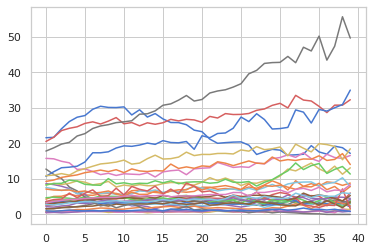

In [395]:
_=plt.plot(coefs.T)

In [460]:
x=pd.DataFrame(index=range(10), columns=['a','b','c'])
x['a']=np.arange(10)
x

,a,b,c
0,0,NaN,NaN
1,1,NaN,NaN
2,2,NaN,NaN
3,3,NaN,NaN
4,4,NaN,NaN
5,5,NaN,NaN
6,6,NaN,NaN
7,7,NaN,NaN
8,8,NaN,NaN
9,9,NaN,NaN


In [426]:
(design_matrix @ fr_sp_m.T).mean()
for unit in 


6.523976325115839

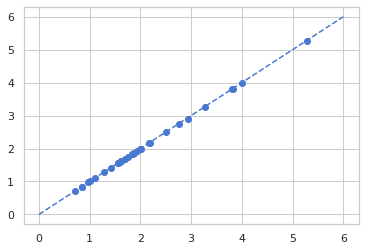

In [151]:
plt.scatter(rmse, rmse_dis)
max_val = 6
plt.plot([0,max_val],[0,max_val],'--')

array([[ 1.        , -0.31163873],
       [-0.31163873,  1.        ]])

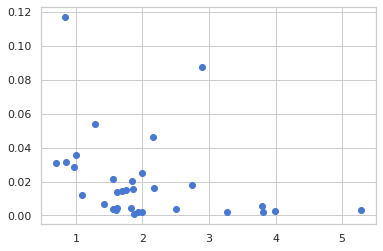

In [155]:
plt.scatter(rmse_dis,ar2_dis)
np.corrcoef(rmse_dis,ar2_dis)

array([[ 1.        , -0.31464363],
       [-0.31464363,  1.        ]])

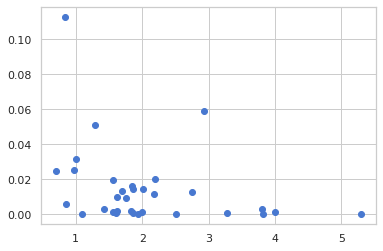

In [156]:
plt.scatter(rmse,ar2)
np.corrcoef(rmse,ar2)

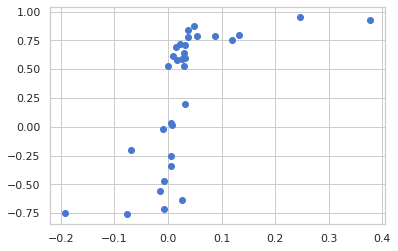

In [170]:
plt.scatter(sp_score,sp_score_dis)

In [66]:
c = np.zeros(session_info.n_units)
for unit in range(session_info.n_units):
    c[unit] = np.corrcoef(fr_maps[unit].flatten(), fr_maps2[unit].flatten())[0,1]

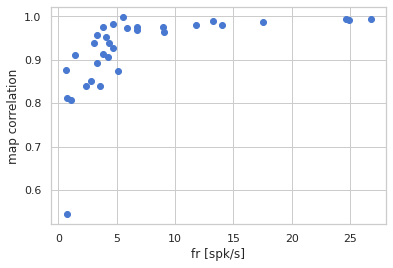

In [82]:
f,ax=plt.subplots()
ax.scatter(fr.mean(axis=1),c)
ax.set_xlabel('fr [spk/s]')
ax.set_ylabel('map correlation')
f.savefig('corr_fr.jpeg')

In [6]:
session_info.__class__.__dict__.keys()

dict_keys(['__module__', '__init__', 'get_time', 'get_raw_track_data', 'get_sorted_tt_dir', 'get_tt_info', 'get_tt_data', 'get_spikes', 'get_binned_spikes', 'get_fr', 'get_spike_maps', 'get_fr_maps', 'get_track_data', '__doc__'])

In [11]:
session_info.get_spikes

<bound method SubjectSessionInfo.get_spikes of <TreeMazeAnalyses2.Analyses.subject_info.SubjectSessionInfo object at 0x7ff9106a4cc0>>

In [9]:
def foo(a):
    if a >0:
        def foo2(b):
            return b
    else:
        def foo2(b):
            return b**2
    return foo2

foo(-1)(2)

4

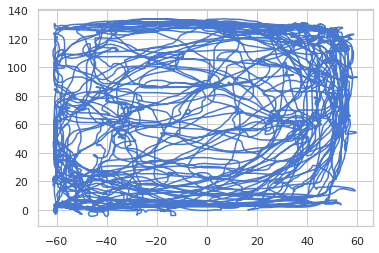

In [10]:
plt.plot(of_track_dat.x,of_track_dat.y)

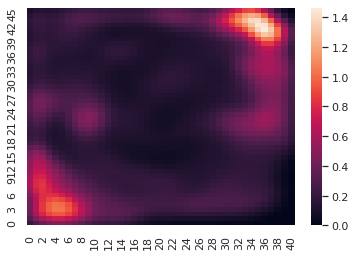

In [12]:
ax=sns.heatmap(of_track_dat.occ_secs)
ax.invert_yaxis()

In [15]:
of_track_dat.hd_stats, of_track_dat.ha_stats

({'r': 28.84468719698725,
  'ang': 2.0712524845854063,
  'R': 33.183017243222295,
  'p_val': 3.849530279921874e-15},
 {'r': 274.2490142671288,
  'ang': -2.662743628777634,
  'R': 2951.5875702544895,
  'p_val': 0.0})

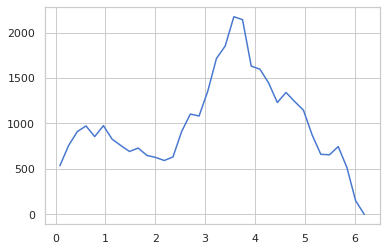

In [25]:
counts,bin_centers,_=spatial_funcs.get_angle_hist(of_track_dat.ha, np.deg2rad(10))
plt.plot(bin_centers,counts)

In [29]:
session_info.task_params

{'x_pix_lims': [100, 650],
 'y_pix_lims': [100, 500],
 'x_pix_bias': -380,
 'y_pix_bias': -280,
 'vt_rate': 0.016666666666666666,
 'xy_pix_rot_rad': 1.6507963267948966,
 'x_pix_mm': 3.7790697674418605,
 'y_pix_mm': 3.265765765765766,
 'x_mm_bias': 0,
 'y_mm_bias': 650,
 'x_mm_lims': [-620, 620],
 'y_mm_lims': [-50, 1350],
 'x_cm_lims': [-62, 62],
 'y_cm_lims': [-5, 135],
 'mm_bin': 30,
 'cm_bin': 3,
 'max_speed_thr': 80,
 'min_speed_thr': 0.5,
 'rad_bin': 0.17453292519943295,
 'time_thr': 0.05,
 'spatial_sigma': 1.5,
 'spatial_window_size': 5,
 'temporal_window_size': 7,
 'temporal_angle_window_size': 7,
 'temporal_window_type': 'hann',
 'filter_coef': array([0.        , 0.08333333, 0.25      , 0.33333333, 0.25      ,
        0.08333333, 0.        ]),
 'filter_coef_angle': array([0.        , 0.08333333, 0.25      , 0.33333333, 0.25      ,
        0.08333333, 0.        ])}

In [12]:
a = np.empty(10)
a[:] = np.NaN
#a>10
with np.errstate(invalid='ignore'):
    a>10


In [7]:
p = SimpleNamespace(**session_info.task_params)

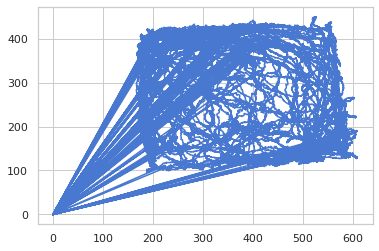

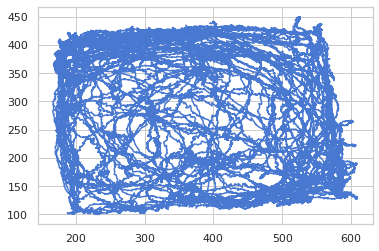

In [22]:
 # 1. mask pixels that are out of bounds
mask_x = np.logical_or(x < p.x_pix_lims[0], x > p.x_pix_lims[1])
mask_y = np.logical_or(y < p.y_pix_lims[0], y > p.y_pix_lims[1])
mask = np.logical_or(mask_x, mask_y)

x[mask] = np.nan
y[mask] = np.nan

plt.plot(x,y)

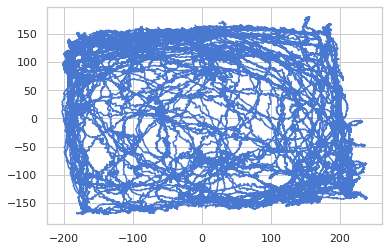

In [27]:
# 2. centering / pixel translation
x2 = x + p.x_pix_bias
y2 = y + p.y_pix_bias
plt.plot(x2,y2)

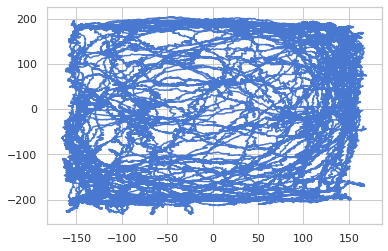

In [30]:
# 3. rotate to experimenter's pov
x3, y3 = spatial_funcs.rotate_xy(x2, y2, p.xy_pix_rot_rad)
plt.plot(x3,y3)

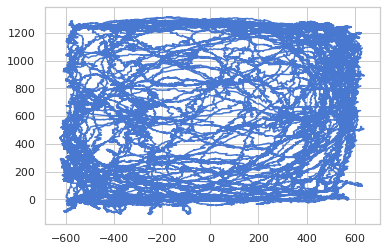

In [97]:
 # 4. convert to mm / re-scales; bias term re-frames the image
x4 = x3 * p.x_pix_mm + p.x_mm_bias
y4 = y3 * p.y_pix_mm + p.y_mm_bias
plt.plot(x4,y4)

/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/alexgonzalez/anaconda3/envs/spk_phy2/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


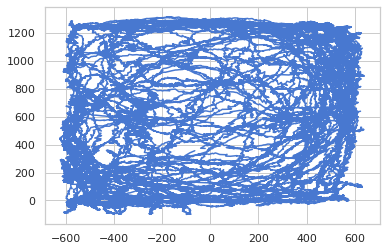

In [98]:
# 5. compute velocity to create speed threshold
dx = np.append(0, np.diff(x4))
dy = np.append(0, np.diff(y4))
dr = np.sqrt(dx ** 2 + dy ** 2)
mask_r = np.abs(dr) > p.speed_thr

# 6. mask creating out of bound zones in mm space
mask_y = np.logical_or(y4 < p.y_mm_lims[0], y4 > p.y_mm_lims[1])
mask_x = np.logical_or(x4 < p.x_mm_lims[0], x4 > p.x_mm_lims[1])
mask = np.logical_or(mask_x, mask_y)
mask = np.logical_or(mask, mask_r)

# 7. apply masks
x4[mask] = np.nan
y4[mask] = np.nan
ha2 = np.array(ha_vt)
ha2[mask] = np.nan
plt.plot(x4,y4)

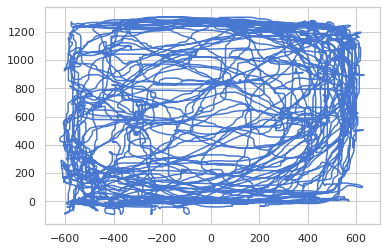

In [101]:
# 8. median filter the data to deal with nan
x5 = filter_funcs.median_window_filtfilt(x4, p.temporal_window_size)
y5 = filter_funcs.median_window_filtfilt(y4, p.temporal_window_size)
ha3 = filter_funcs.median_window_filtfilt(ha2, p.temporal_angle_window_size)

plt.plot(x5,y5)

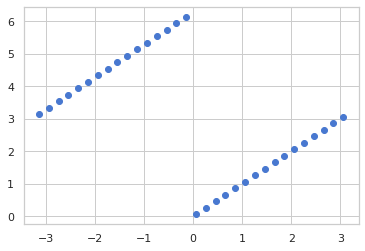

In [113]:
th = np.arange(-np.pi, np.pi,0.2)
th2 = np.mod(th,2*np.pi)
plt.scatter(th,th2)

In [121]:
def foo():
    def foo2(a):
        return a+2
    def foo3(a):
        return a+3
    
foo().foo2(1)

AttributeError: 'NoneType' object has no attribute 'foo2'

(array([2579.,  973.,  743.,  729.,  767.,  566.,  677.,  527.,  252.,
         920.,  358.,  349.,  343.,  560.,  741.,  965.,  996.,  650.,
        2268., 1919., 1645., 1895., 1624., 1296., 1312., 1186.,  545.,
        1878.,  848.,  896.,  797.,  947.,  993.,  944.,  906.,  501.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]),
 <a list of 36 Patch objects>)

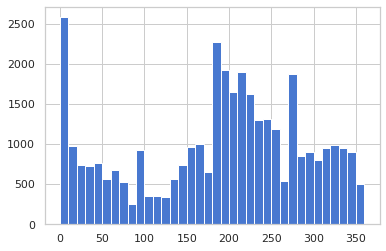

In [36]:
plt.hist(ha_rs, bins=bins)

In [39]:
ha_rs_bin,_=np.histogram(ha_rs,bins=bins)
ha_vt_bin,_=np.histogram(ha_vt,bins=bins)

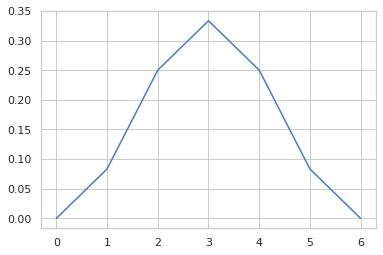

In [125]:
window = signal.get_window('hann',7,fftbins=False)
window /= window.sum()
plt.plot(window)

In [55]:
from Analyses.spatial_functions import get_angle_xy



In [126]:
window = signal.get_window('hann',7,fftbins=False)
window /= window.sum()



In [161]:
1450/444*200

653.1531531531532

(array([1179.,  862.,  727.,  594.,  593.,  687.,  694.,  697.,  712.,
         830.,  617.,  533.,  448.,  507.,  659.,  731.,  827.,  985.,
        1310., 1475., 1785., 1731., 1580., 1550., 1578., 1482., 1605.,
        1390., 1198.,  993.,  966.,  892.,  838.,  824.,  993., 1023.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]),
 <a list of 36 Patch objects>)

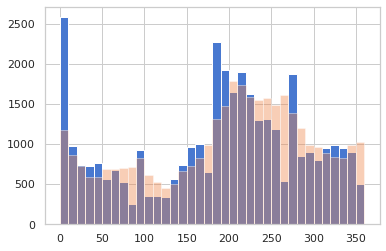

In [127]:
ha_f = get_angle_xy(ha_xf,ha_yf2)
ha_f = np.mod(np.rad2deg(ha_f),360)
plt.hist(ha_rs,bins)
plt.hist(ha_f,bins,alpha=0.4)

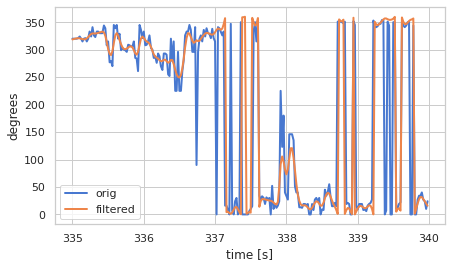

In [159]:
i = 67
sl = np.arange(250)+i*250
f,ax=plt.subplots(figsize=(7,4))
ax.plot(t_rs[sl]-t_rs[0], ha_rs[sl], linewidth=2, label='orig')
ax.plot(t_rs[sl]-t_rs[0], ha_f[sl],linewidth=2,label='filtered')
ax.legend(loc='best')
ax.set_xlabel('time [s]')
ax.set_ylabel('degrees')
f.savefig('circ_filter_examp.jpg')

In [152]:
!pwd

/home/alexgonzalez/Documents


In [4]:
tr, to = session_info.get_session_time_vectors(session)

In [11]:
spike_trains, spike_train_ids, wfi = session_info.get_spikes()

In [13]:
bin_spikes = session_info.get_binned_spikes()
fr = session_info.get_fr()

In [23]:
t,x,y,ha = session_info.get_track_dat()

array([23719.500525, 23719.516   , 23719.531476, ..., 24441.237229,
       24441.254386, 24441.270366])

In [13]:
def add2(a,b):
    a=a+2
    return a+b

In [16]:
import h5py
_track_data_file = session_info.paths['PreProcessed'] / 'vt.h5'

f = h5py.File(_track_data_file, 'r')
t_vt = np.array(f['t'])
x = np.array(f['x'])
y = np.array(f['y'])
ha = np.array(f['ha'])

In [20]:
f.keys()

<KeysViewHDF5 ['ha', 't', 'x', 'y']>

In [132]:
from TreeMazeAnalyses2.Analyses import spike_functions as SF
SF = reload(SF)

In [7]:
spike_trains, spike_train_ids, wfi = SF.get_session_spikes(subject_info,session, overwrite=True)

Spikes Files not Found or overwrite=1, creating them.


In [9]:
bin_spikes = SF.get_session_binned_spikes(subject_info,session,spike_trains)

In [10]:
np.array([len(x) for x in spike_trains]).sum() == bin_spikes.sum()

True

In [133]:
fr = SF.get_session_fr(subject_info, session, overwrite=True)


Firing Rate Files Not Found or overwrite=1, creating them.


In [99]:
i = 4
sl = i*50+np.arange(0,50,dtype=int)
(bin_spikes[0][sl]).sum(), fr4[sl].mean(), fr5[sl].mean()

(15.0, 15.338106903722808, 15.41)

In [122]:
time_step=0.02
filter_len = np.round(0.125 / time_step).astype(int)
filt_coeff = signal.windows.hann(filter_len)
fr4 = signal.filtfilt(filt_coeff/np.sum(filt_coeff),1,bin_spikes[0]/time_step)
fr5 = signal.filtfilt(np.ones(filter_len)/filter_len,1,bin_spikes[0]/time_step)

i = 10
sl = i*50+np.arange(0,50,dtype=int)
print(np.around(fr4[sl]), np.around(fr5[sl]), bin_spikes[0][sl]/time_step, sep='\n')
print()
print((bin_spikes[0][sl]).sum()/len(sl)/time_step, fr4[sl].mean(), fr5[sl].mean())

[67. 62. 60. 63. 70. 72. 61. 44. 35. 32. 29. 28. 35. 48. 55. 49. 40. 39.
 44. 42. 31. 26. 38. 50. 48. 40. 38. 36. 30. 27. 28. 28. 22. 18. 22. 28.
 32. 32. 28. 22. 18. 18. 26. 35. 35. 25. 16. 18. 27. 28.]
[68. 68. 67. 62. 62. 60. 54. 47. 42. 40. 37. 36. 37. 42. 44. 44. 43. 40.
 42. 40. 37. 36. 39. 43. 39. 37. 37. 37. 32. 28. 28. 26. 25. 24. 26. 26.
 26. 26. 25. 26. 25. 25. 25. 25. 28. 25. 24. 24. 25. 26.]
[ 50.  50. 100.   0. 100. 100.  50.  50.   0.  50.  50.   0.   0. 100.
  50.  50.  50.   0.  50. 100.   0.   0.   0. 150.   0.  50.   0. 100.
   0.   0.  50.  50.   0.   0.  50.   0.  50.  50.   0.  50.   0.   0.
  50.   0. 100.   0.   0.   0.  50.  50.]

37.0 36.9 37.11111111111111


array([[1.        , 0.63004319],
       [0.63004319, 1.        ]])

In [92]:
def aggregate_spikes_numpy(cell_spikes, cell_tt_cl, mua_spikes, mua_tt_cl):
    """
    Wrapper function for get_spikes_numpy
    Deals with Cell and Mua subcategories
    :param cell_spikes: numpy output of get_spikes_numpy
    :param cell_tt_cl: dict output of get_spikes_numpy
    :param mua_spikes: numpy output of get_spikes_numpy
    :param mua_tt_cl: dict output of get_spikes_numpy
    :returns: spikes. single object array containing both cell and mua spikes
    :returns: tt_cl. single dict containing the indices and identification info for each cluster
    """
    spikes = np.concatenate((cell_spikes, mua_spikes))
    n_cell_units = len(cell_spikes)
    n_mua_units = len(mua_spikes)
    n_units = n_cell_units + n_mua_units
    tt_cl = {}
    for unit in range(n_cell_units):
        tt_cl[unit] = ('Cell',) + cell_tt_cl[unit]
    for unit in range(n_mua_units):
        tt_cl[unit+n_cell_units] = ('Mua',) + mua_tt_cl[unit]

    return spikes, tt_cl


def get_spikes_numpy(spikes):
    n_units = spikes['n_units']
    spikes2 = np.empty(n_units, dtype=object)
    tt_cl = {}
    cnt = 0
    for tt in cell_spikes.keys():
        if tt=='n_units':
            continue
        for cl, spks in spikes[tt].items():
            spikes2[cnt] = np.array(spks).astype(np.int32)
            tt_cl[cnt] = tt,cl
            cnt+=1
            
    return spikes2, tt_cl

In [95]:
cell_spikes2,cell_tt_cl =get_spikes_numpy(cell_spikes)
mua_spikes2,mua_tt_cl =get_spikes_numpy(mua_spikes)

In [96]:
spikes, tt_cl = aggregate_spikes_numpy(cell_spikes2,cell_tt_cl,mua_spikes2,mua_tt_cl)

In [101]:
spikes.shape, tt_cl

((32,),
 {0: ('Cell', '3', '13'),
  1: ('Cell', '8', '0'),
  2: ('Cell', '8', '1'),
  3: ('Cell', '8', '3'),
  4: ('Cell', '8', '4'),
  5: ('Cell', '8', '5'),
  6: ('Cell', '8', '6'),
  7: ('Cell', '10', '1'),
  8: ('Cell', '10', '8'),
  9: ('Cell', '10', '9'),
  10: ('Cell', '10', '12'),
  11: ('Cell', '10', '14'),
  12: ('Cell', '14', '13'),
  13: ('Cell', '14', '15'),
  14: ('Mua', '3', '2'),
  15: ('Mua', '3', '6'),
  16: ('Mua', '3', '7'),
  17: ('Mua', '5', '9'),
  18: ('Mua', '7', '4'),
  19: ('Mua', '7', '5'),
  20: ('Mua', '7', '6'),
  21: ('Mua', '7', '7'),
  22: ('Mua', '7', '8'),
  23: ('Mua', '7', '10'),
  24: ('Mua', '10', '13'),
  25: ('Mua', '10', '16'),
  26: ('Mua', '10', '17'),
  27: ('Mua', '14', '0'),
  28: ('Mua', '14', '1'),
  29: ('Mua', '14', '9'),
  30: ('Mua', '14', '10'),
  31: ('Mua', '14', '11')})

In [53]:
clusters = subject_info.clusters[session]

In [54]:
clusters['cell_IDs'][]

{'3': [13],
 '5': [],
 '6': [],
 '7': [],
 '8': [0, 1, 3, 4, 5, 6],
 '9': [],
 '10': [1, 8, 9, 12, 14],
 '13': [],
 '14': [13, 15]}

In [64]:
[len(x[i]) for i in range(len(x))]

[17794,
 4274,
 3104,
 2753,
 3380,
 2794,
 9565,
 2020,
 548,
 2178,
 2382,
 1062,
 2951,
 18008]

In [6]:
#subject_info.clusters[session]
#subject_info.session_paths[session]
tt=8

clusters = subject_info.clusters[session]
sort_dir = subject_info.get_session_sorted_tt_dir(session,tt)
spk_times = np.load(sort_dir/'spike_times.npy').flatten()
cluster_spks = np.load(sort_dir/'spike_clusters.npy')
session_paths = subject_info.session_paths[session]
tt_dat = subject_info.get_session_tt_data(session,tt)



In [8]:
cl = 0
unit_ids = clusters['cell_IDs'][str(tt)]
cl_spks = spk_times[cluster_spks==unit_ids[cl]]


In [90]:
def get_waveform_info(spikes, waveforms, n_samps, samp_rate):

    waveforms = waveforms.astype(np.float32)
    n_spk = len(spikes)
    wfi = {'mean': np.nanmean(waveforms, axis=0),
           'std': np.nanstd(waveforms, axis=0),
           'sem': stats.sem(waveforms, axis=0),
           'nSp': n_spk,
           't_stat': stats.ttest_1samp(waveforms, 0, axis=0)[0],
           'm_fr': n_spk / n_samps * samp_rate}

    # isi in ms
    isi = np.diff(spikes)/samp_rate*1000
    wfi['isi_h'] = np.histogram(isi, bins=np.linspace(-1, 20, 25))
    wfi['cv'] = np.std(isi)/np.mean(isi)
    return wfi

def get_wf_samps(spikes):
    # inputs: spikes 1d np.array of integers indicating indices of spikes
    # output: np.ndarray n_spikes x 64 of integers
    a = np.zeros((len(spikes), 64), dtype=np.int)
    cnt = 0
    for s in spikes:
        a[cnt] = s+np.arange(64)-32
        cnt += 1
    return a


def get_waveforms(spikes, data):
    # inputs:
    #  -> spikes: 1d array of spike ids
    #  -> data: nd.array of size n_channels x n_samps
    # outputs:
    #  -> nd.array of shape  n_spikes x 64 x n_chans
    wf_samps = get_wf_samps(spikes) 
    return np.moveaxis(data[:, wf_samps], 0, -1)

def get_wf_outliers(waveforms, thr=0):
    # waveforms = nSpikes x 64 x 4 np.array
    n_spk, n_samps, n_ch = waveforms.shape
    n_feat = n_samps*n_ch
    
    X = np.reshape(waveforms,(n_spk,-1))

    Xm = np.nanmedian(X,0)
    Y = np.zeros(n_spk)
    for s in np.arange(n_spk)
        Y[s] = spatial.distance.braycurtis(Xm,X[s])
    bad_spikes = Y > thr
    # pca = PCA(n_components=2)
    # pca.fit(X)
    # lls = pca.score_samples(X)
    # badSpikes = np.abs(robust_zscore(lls))>thr
    return bad_spikes, Y

In [91]:
x=get_waveforms(cl_spks,tt_dat)

In [92]:
y = get_waveform_info(cl_spks,x,tt_dat.shape[1],32000)

In [128]:
x2 = x.reshape((x.shape[0],-1))
Xm = np.nanmedian(x2,0)

In [163]:
n_spk = x.shape[0]
x2 = x.reshape((n_spk,-1)).astype(np.float32)
Xm = np.nanmedian(x2,0)
x2 = x2-Xm
dists = np.zeros(n_spk)
for spk in range(n_spk):
    #dists[spk] = spatial.distance.sqeuclidean(Xm,x2[spk],np.abs(Xm)/np.sum(np.abs(Xm)))
    dists[spk] = spatial.distance.sqeuclidean(Xm,x2[spk])
    

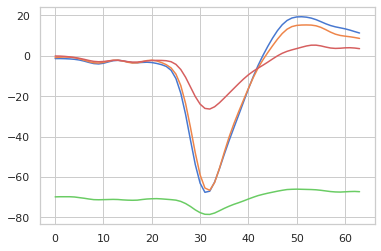

In [165]:
plt.plot(x[dists>dists.mean()].mean(axis=0))

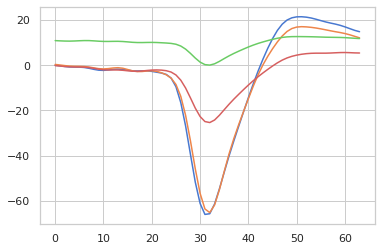

In [166]:
plt.plot(x[dists<dists.mean()].mean(axis=0))

(array([  18.,   48.,  179., 1281.,  612.,  565., 1306.,  226.,   46.,
          12.]),
 array([0.2365793 , 0.38878208, 0.54098487, 0.69318765, 0.84539044,
        0.99759322, 1.14979601, 1.30199879, 1.45420158, 1.60640436,
        1.75860715]),
 <a list of 10 Patch objects>)

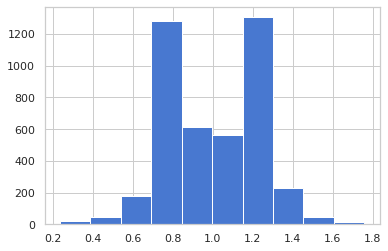

In [160]:
plt.hist(dists)